# Testing Convergence Criteria Changes on Real Data

This notebook validates the convergence-criteria refactoring applied to `logit-graph`:

**Path 1 — `populate_edges_spectrum_min_gic` (fitter, with ground truth):**
- Spectrum & GIC are now computed every `check_interval` steps (not every iteration).
- GIC is checked on a fixed schedule, decoupled from the spectrum-improvement branch.
- `pbar.write` / `pbar.close` ordering is fixed.
- `edge_delta` lower-bound no-op removed.

**Path 2 — `populate_edges_baseline` (simulation, no ground truth):**
- Trivially-true absolute thresholds replaced with **coefficient of variation** (CV) convergence.
- Spectrum only computed at periodic checkpoints.
- `deque` replaces `list` + `pop(0)`.

We test on connectome brain graphs of varying size.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, time
sys.path.insert(0, '../../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

from logit_graph.simulation import (
    LogitGraphFitter,
    LogitGraphSimulation,
    GraphModelComparator,
    calculate_graph_attributes,
)
from logit_graph.logit_estimator import LogitRegEstimator
from logit_graph.gic import GraphInformationCriterion
from logit_graph.graph import GraphModel

sns.set_style('whitegrid')
plt.rcParams.update({'figure.figsize': (14, 5), 'font.size': 11})
print('Imports OK')

Imports OK


## 1. Load real graphs

We use two connectome datasets that were already used in the previous notebook:
- **Small** (29 nodes): `mouse_visual.cortex_1`
- **Medium** (65 nodes): `mixed.species_brain_1`

In [3]:
DATA_DIR = '../../data/connectomes/'

G_small = nx.read_graphml(DATA_DIR + 'mouse_visual.cortex_1.graphml').to_undirected()
G_medium = nx.read_graphml(DATA_DIR + 'mixed.species_brain_1.graphml').to_undirected()

for name, G in [('mouse_visual.cortex_1 (small)', G_small),
                ('mixed.species_brain_1 (medium)', G_medium)]:
    print(f'{name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges, '
          f'density={nx.density(G):.4f}')

mouse_visual.cortex_1 (small): 29 nodes, 44 edges, density=0.1084
mixed.species_brain_1 (medium): 65 nodes, 730 edges, density=0.3510


---
## 2. Baseline convergence (no ground truth)

The old `populate_edges_baseline` used absolute thresholds (`threshold_edges=10`,
`threshold_spectrum=100`) that were **trivially satisfied** after just one step
past warm-up.  The new version uses a rolling **coefficient of variation (CV)**
test over periodic checkpoints.

### 2.1 Show the baseline actually iterates past warm-up

In [4]:
# Estimate parameters from the small connectome so we have realistic sigma/beta
adj_small = nx.to_numpy_array(G_small)
est = LogitRegEstimator(adj_small, d=1)
features, labels = est.get_features_labels()
_, params, _ = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
sigma_est, beta_est = params[0], params[1]
print(f'Estimated sigma={sigma_est:.4f}, beta={beta_est:.4f}')

np.random.seed(42)
n = G_small.number_of_nodes()
gm = GraphModel(n=n, d=1, sigma=sigma_est, beta=beta_est, er_p=0.05)

WARM_UP = 500
MAX_ITER = 8000
PATIENCE = 15
CHECK_INTERVAL = 50

t0 = time.time()
graphs_bl, spectra_bl = gm.populate_edges_baseline(
    warm_up=WARM_UP, max_iterations=MAX_ITER, patience=PATIENCE,
    check_interval=CHECK_INTERVAL, edge_cv_tol=0.02, spectrum_cv_tol=0.02,
)
elapsed = time.time() - t0

print(f'\nNumber of graph snapshots stored: {len(graphs_bl)}')
print(f'Final edge count: {int(np.sum(np.triu(graphs_bl[-1])))}')
print(f'Elapsed: {elapsed:.2f}s')
assert len(graphs_bl) > 2, 'FAIL: baseline stopped trivially at warm-up!'
print('PASS: baseline iterated meaningfully past warm-up.')

Estimated sigma=-3.1754, beta=0.0253


Generating graph:   0%|          | 0/8000 [00:00<?, ?it/s]


Number of graph snapshots stored: 161
Final edge count: 18
Elapsed: 0.43s
PASS: baseline iterated meaningfully past warm-up.


### 2.2 Effect of CV tolerances on convergence

Run the baseline with different `edge_cv_tol` / `spectrum_cv_tol` values and
observe how tight tolerances require more iterations.

Generating graph:   0%|          | 0/8000 [00:00<?, ?it/s]

tol=0.10  snapshots=  20  edges=  26  time=0.06s


Generating graph:   0%|          | 0/8000 [00:00<?, ?it/s]

tol=0.05  snapshots= 161  edges=  18  time=0.39s


Generating graph:   0%|          | 0/8000 [00:00<?, ?it/s]

tol=0.02  snapshots= 161  edges=  18  time=0.50s


Generating graph:   0%|          | 0/8000 [00:00<?, ?it/s]

tol=0.01  snapshots= 161  edges=  18  time=0.38s


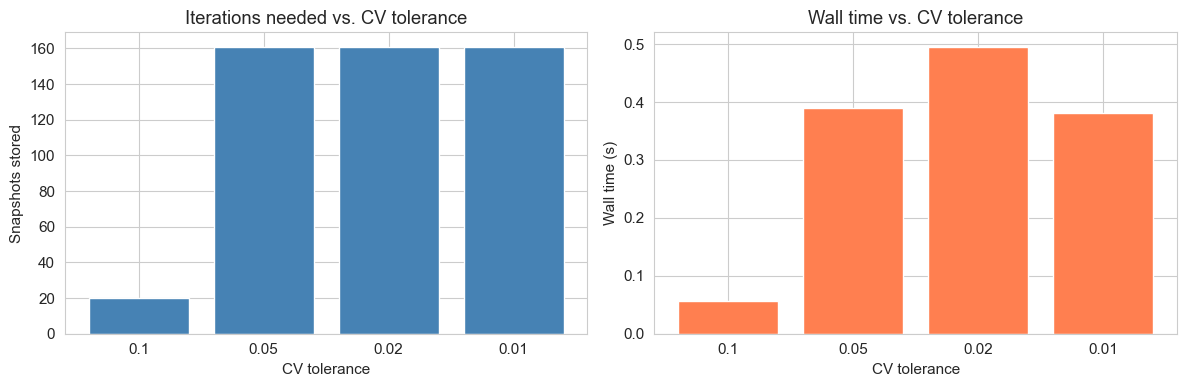

In [5]:
tol_values = [0.10, 0.05, 0.02, 0.01]
results_bl = []

for tol in tol_values:
    np.random.seed(42)
    gm_tmp = GraphModel(n=n, d=1, sigma=sigma_est, beta=beta_est, er_p=0.05)
    t0 = time.time()
    gs, sp = gm_tmp.populate_edges_baseline(
        warm_up=WARM_UP, max_iterations=MAX_ITER, patience=PATIENCE,
        check_interval=CHECK_INTERVAL, edge_cv_tol=tol, spectrum_cv_tol=tol,
    )
    elapsed = time.time() - t0
    final_edges = int(np.sum(np.triu(gs[-1])))
    results_bl.append({
        'tol': tol, 'snapshots': len(gs),
        'final_edges': final_edges, 'elapsed': elapsed,
    })
    print(f'tol={tol:.2f}  snapshots={len(gs):>4}  edges={final_edges:>4}  time={elapsed:.2f}s')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
tols = [r['tol'] for r in results_bl]
ax[0].bar([str(t) for t in tols], [r['snapshots'] for r in results_bl], color='steelblue')
ax[0].set_xlabel('CV tolerance'); ax[0].set_ylabel('Snapshots stored')
ax[0].set_title('Iterations needed vs. CV tolerance')

ax[1].bar([str(t) for t in tols], [r['elapsed'] for r in results_bl], color='coral')
ax[1].set_xlabel('CV tolerance'); ax[1].set_ylabel('Wall time (s)')
ax[1].set_title('Wall time vs. CV tolerance')
plt.tight_layout()
plt.show()

### 2.3 Baseline quality — degree & spectrum distributions

Even without a ground-truth reference, the baseline graph should be a stable
realisation of the logit model.  We compare the final baseline graph with the
real graph it was seeded from.

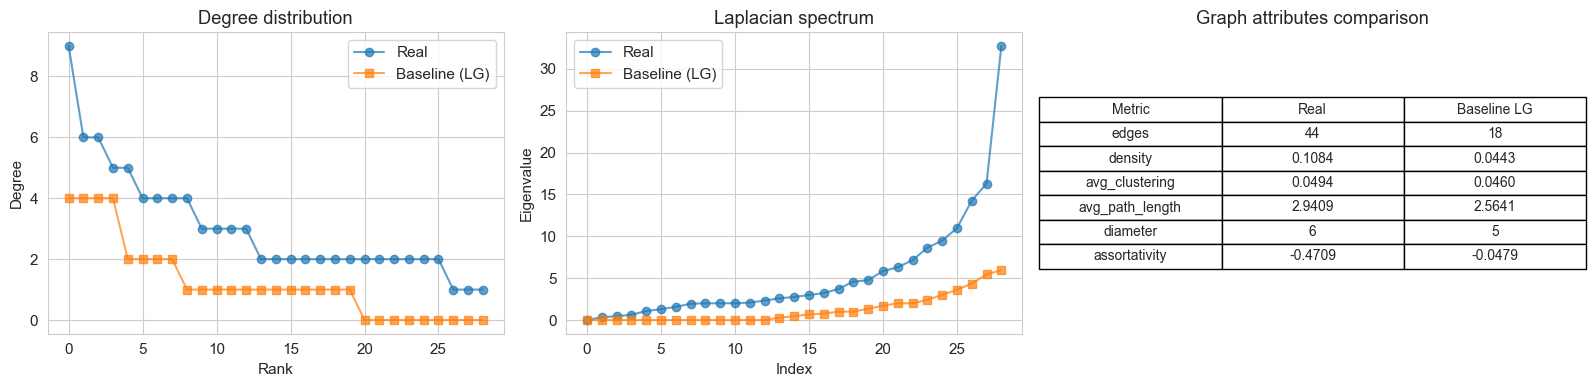

In [6]:
final_bl = graphs_bl[-1]
G_bl = nx.from_numpy_array(final_bl)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Degree distribution
deg_real = sorted([d for _, d in G_small.degree()], reverse=True)
deg_bl = sorted([d for _, d in G_bl.degree()], reverse=True)
axes[0].plot(deg_real, 'o-', label='Real', alpha=0.7)
axes[0].plot(deg_bl, 's-', label='Baseline (LG)', alpha=0.7)
axes[0].set_xlabel('Rank'); axes[0].set_ylabel('Degree')
axes[0].set_title('Degree distribution'); axes[0].legend()

# Spectrum comparison
spec_real = GraphModel.calculate_spectrum(adj_small)
spec_bl = GraphModel.calculate_spectrum(final_bl)
axes[1].plot(spec_real, 'o-', label='Real', alpha=0.7)
axes[1].plot(spec_bl, 's-', label='Baseline (LG)', alpha=0.7)
axes[1].set_xlabel('Index'); axes[1].set_ylabel('Eigenvalue')
axes[1].set_title('Laplacian spectrum'); axes[1].legend()

# Graph attributes table
attrs_real = calculate_graph_attributes(G_small)
attrs_bl = calculate_graph_attributes(G_bl)
keys = ['edges', 'density', 'avg_clustering', 'avg_path_length', 'diameter', 'assortativity']
table_data = [[k, f"{attrs_real.get(k, 'N/A'):.4f}" if isinstance(attrs_real.get(k), float) else attrs_real.get(k),
               f"{attrs_bl.get(k, 'N/A'):.4f}" if isinstance(attrs_bl.get(k), float) else attrs_bl.get(k)]
              for k in keys]
axes[2].axis('off')
tbl = axes[2].table(cellText=table_data, colLabels=['Metric', 'Real', 'Baseline LG'],
                     loc='center', cellLoc='center')
tbl.auto_set_font_size(False); tbl.set_fontsize(10); tbl.scale(1.2, 1.5)
axes[2].set_title('Graph attributes comparison')

plt.tight_layout()
plt.show()

---
## 3. Fitter convergence (with ground truth)

The refactored `populate_edges_spectrum_min_gic` now:
1. Computes GIC **every** `check_interval` steps (not conditionally).
2. Computes spectrum only at those checkpoints.
3. Counts patience in *checks*, not raw iterations.

### 3.1 Two-phase convergence visualisation

In [7]:
np.random.seed(42)
gm_fit = GraphModel(n=n, d=1, sigma=sigma_est, beta=beta_est, er_p=0.05)

MAX_ITER_FIT = 5000
PATIENCE_FIT = 30
GIC_THRESHOLD = 5
CHECK_INTERVAL_FIT = 50

t0 = time.time()
graphs_fit, spectra_fit, spectrum_diffs, best_iter, best_graph, gic_values = \
    gm_fit.populate_edges_spectrum_min_gic(
        max_iterations=MAX_ITER_FIT,
        patience=PATIENCE_FIT,
        real_graph=adj_small,
        min_gic_threshold=GIC_THRESHOLD,
        check_interval=CHECK_INTERVAL_FIT,
        gic_dist_type='KL',
        verbose=True,
    )
elapsed_fit = time.time() - t0

print(f'\nBest iteration: {best_iter}')
print(f'Number of GIC measurements: {len(gic_values)}')
print(f'Number of spectrum measurements: {len(spectrum_diffs)}')
print(f'Elapsed: {elapsed_fit:.2f}s')

Optimizing Graph:   0%|          | 0/5000 [00:00<?, ?it/s] 


Stopping: max iterations (5,000) reached
  Best iteration: 450
  Best spectrum diff: 24.7412
  Edges in best graph: 49 (real: 77)

Best iteration: 450
Number of GIC measurements: 100
Number of spectrum measurements: 100
Elapsed: 0.38s


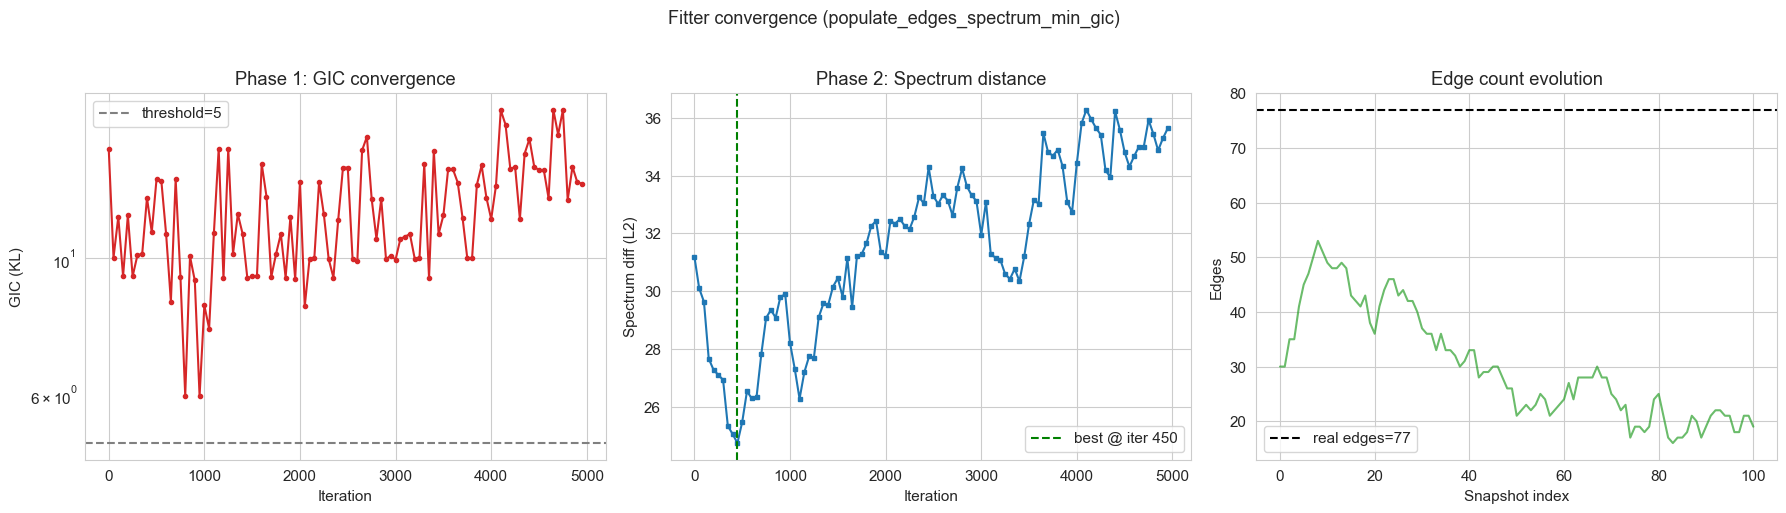

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GIC over checks
check_iters_gic = np.arange(len(gic_values)) * CHECK_INTERVAL_FIT
axes[0].plot(check_iters_gic, gic_values, 'o-', markersize=3, color='tab:red')
axes[0].axhline(GIC_THRESHOLD, ls='--', color='gray', label=f'threshold={GIC_THRESHOLD}')
axes[0].set_xlabel('Iteration'); axes[0].set_ylabel('GIC (KL)')
axes[0].set_title('Phase 1: GIC convergence')
axes[0].legend(); axes[0].set_yscale('log')

# Spectrum diff over checks
check_iters_spec = np.arange(len(spectrum_diffs)) * CHECK_INTERVAL_FIT
axes[1].plot(check_iters_spec, spectrum_diffs, 's-', markersize=3, color='tab:blue')
if best_iter is not None:
    axes[1].axvline(best_iter, ls='--', color='green', label=f'best @ iter {best_iter}')
axes[1].set_xlabel('Iteration'); axes[1].set_ylabel('Spectrum diff (L2)')
axes[1].set_title('Phase 2: Spectrum distance')
axes[1].legend()

# Edge count evolution
edge_counts = [int(np.sum(np.triu(g))) for g in graphs_fit]
real_edges = int(np.sum(np.triu(adj_small)))
axes[2].plot(edge_counts, '-', color='tab:green', alpha=0.7)
axes[2].axhline(real_edges, ls='--', color='black', label=f'real edges={real_edges}')
axes[2].set_xlabel('Snapshot index'); axes[2].set_ylabel('Edges')
axes[2].set_title('Edge count evolution'); axes[2].legend()

plt.suptitle('Fitter convergence (populate_edges_spectrum_min_gic)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### 3.2 Fitter output quality

Compare the best graph found by the fitter against the real graph.

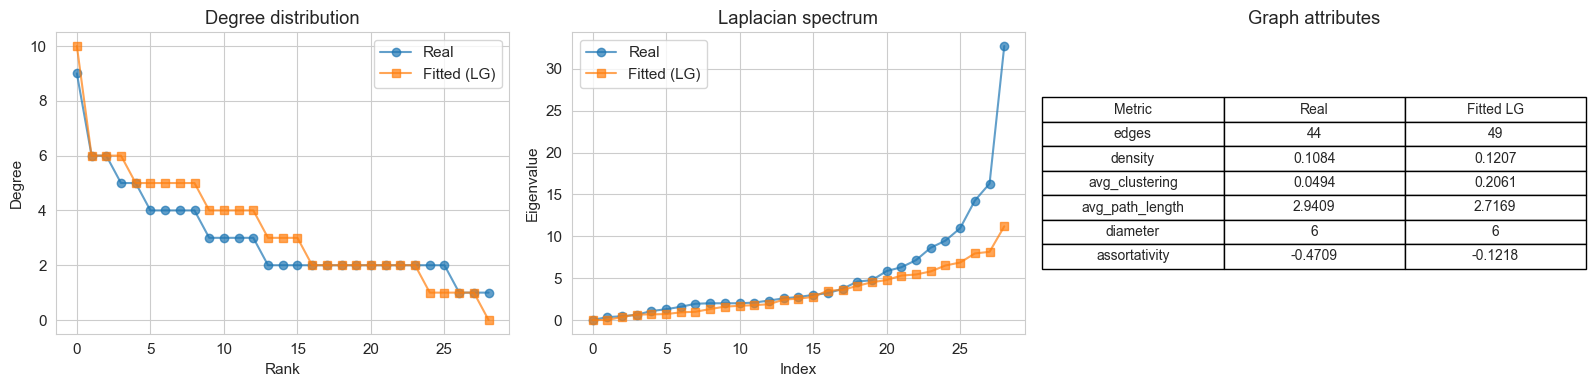

In [9]:
G_fitted = nx.from_numpy_array(best_graph)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

deg_real = sorted([d for _, d in G_small.degree()], reverse=True)
deg_fit = sorted([d for _, d in G_fitted.degree()], reverse=True)
axes[0].plot(deg_real, 'o-', label='Real', alpha=0.7)
axes[0].plot(deg_fit, 's-', label='Fitted (LG)', alpha=0.7)
axes[0].set_xlabel('Rank'); axes[0].set_ylabel('Degree')
axes[0].set_title('Degree distribution'); axes[0].legend()

spec_real = GraphModel.calculate_spectrum(adj_small)
spec_fit = GraphModel.calculate_spectrum(best_graph)
axes[1].plot(spec_real, 'o-', label='Real', alpha=0.7)
axes[1].plot(spec_fit, 's-', label='Fitted (LG)', alpha=0.7)
axes[1].set_xlabel('Index'); axes[1].set_ylabel('Eigenvalue')
axes[1].set_title('Laplacian spectrum'); axes[1].legend()

attrs_real = calculate_graph_attributes(G_small)
attrs_fit = calculate_graph_attributes(G_fitted)
keys = ['edges', 'density', 'avg_clustering', 'avg_path_length', 'diameter', 'assortativity']
table_data = [[k, f"{attrs_real.get(k, 'N/A'):.4f}" if isinstance(attrs_real.get(k), float) else attrs_real.get(k),
               f"{attrs_fit.get(k, 'N/A'):.4f}" if isinstance(attrs_fit.get(k), float) else attrs_fit.get(k)]
              for k in keys]
axes[2].axis('off')
tbl = axes[2].table(cellText=table_data, colLabels=['Metric', 'Real', 'Fitted LG'],
                     loc='center', cellLoc='center')
tbl.auto_set_font_size(False); tbl.set_fontsize(10); tbl.scale(1.2, 1.5)
axes[2].set_title('Graph attributes')

plt.tight_layout()
plt.show()

---
## 4. Effect of `check_interval` on cost vs. quality

Larger `check_interval` means fewer expensive eigendecompositions but coarser
convergence tracking.  We sweep over several values.

check_interval=  10  best_iter= 1090  spec_diff=28.8492  final_gic=10.9178  n_checks= 500  time=0.73s
check_interval=  25  best_iter= 1100  spec_diff=30.2542  final_gic=13.2134  n_checks= 200  time=0.38s
check_interval=  50  best_iter= 1100  spec_diff=30.6062  final_gic=13.2134  n_checks= 100  time=0.26s
check_interval= 100  best_iter= 3400  spec_diff=30.3444  final_gic=13.2996  n_checks=  50  time=0.19s
check_interval= 200  best_iter= 1000  spec_diff=30.2609  final_gic=12.4444  n_checks=  25  time=0.15s


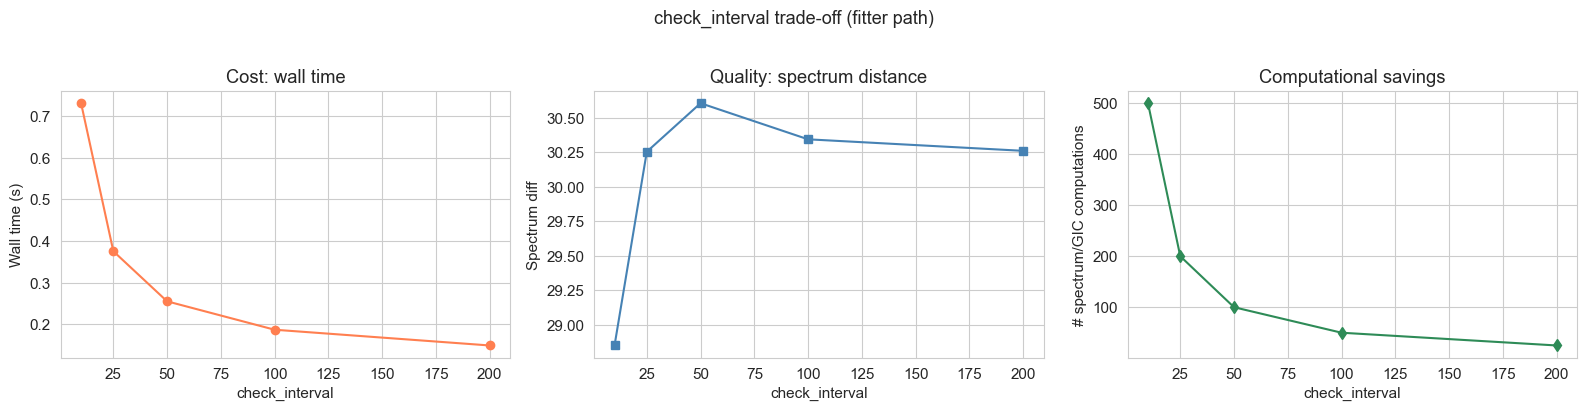

In [10]:
intervals = [10, 25, 50, 100, 200]
results_ci = []

for ci in intervals:
    np.random.seed(42)
    gm_ci = GraphModel(n=n, d=1, sigma=sigma_est, beta=beta_est, er_p=0.05)
    t0 = time.time()
    _, _, sd, bi, bg, gv = gm_ci.populate_edges_spectrum_min_gic(
        max_iterations=5000, patience=30, real_graph=adj_small,
        min_gic_threshold=GIC_THRESHOLD, check_interval=ci, verbose=False,
    )
    elapsed = time.time() - t0
    spec_diff = float(np.linalg.norm(
        GraphModel.calculate_spectrum(bg) - GraphModel.calculate_spectrum(adj_small)))
    final_gic = gv[-1] if gv else float('inf')
    results_ci.append({
        'check_interval': ci, 'best_iter': bi,
        'spectrum_diff': spec_diff, 'final_gic': final_gic,
        'n_checks': len(sd), 'elapsed': elapsed,
    })
    print(f'check_interval={ci:>4}  best_iter={bi:>5}  spec_diff={spec_diff:.4f}  '
          f'final_gic={final_gic:.4f}  n_checks={len(sd):>4}  time={elapsed:.2f}s')

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
cis = [r['check_interval'] for r in results_ci]

axes[0].plot(cis, [r['elapsed'] for r in results_ci], 'o-', color='coral')
axes[0].set_xlabel('check_interval'); axes[0].set_ylabel('Wall time (s)')
axes[0].set_title('Cost: wall time')

axes[1].plot(cis, [r['spectrum_diff'] for r in results_ci], 's-', color='steelblue')
axes[1].set_xlabel('check_interval'); axes[1].set_ylabel('Spectrum diff')
axes[1].set_title('Quality: spectrum distance')

axes[2].plot(cis, [r['n_checks'] for r in results_ci], 'd-', color='seagreen')
axes[2].set_xlabel('check_interval'); axes[2].set_ylabel('# spectrum/GIC computations')
axes[2].set_title('Computational savings')

plt.suptitle('check_interval trade-off (fitter path)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 5. End-to-end `LogitGraphFitter`

The high-level `LogitGraphFitter` class now accepts `check_interval` and
forwards it to `populate_edges_spectrum_min_gic`.

In [11]:
fitter = LogitGraphFitter(
    d=1,
    n_iteration=5000,
    patience=30,
    dist_type='KL',
    min_gic_threshold=5,
    check_interval=50,
    er_p=0.05,
    verbose=True,
)
fitter.fit(G_small)

print('\n=== Fitter Metadata ===')
for k in ['fit_success', 'sigma', 'beta', 'gic_value', 'best_iteration',
          'fitted_nodes', 'fitted_edges']:
    v = fitter.metadata.get(k, 'MISSING')
    if isinstance(v, float):
        print(f'  {k}: {v:.6f}')
    else:
        print(f'  {k}: {v}')

assert fitter.metadata.get('fit_success'), 'FAIL: fit did not succeed'
print('\nPASS: LogitGraphFitter completed successfully with check_interval support.')


==================== Processing Graph ====================
Original graph - Nodes: 29, Edges: 44
Running LG generation for d=1...


Optimizing Graph:   0%|          | 0/5000 [00:00<?, ?it/s] 


Stopping: max iterations (5,000) reached
  Best iteration: 1,250
  Best spectrum diff: 33.4813
  Edges in best graph: 24 (real: 77)
Fitting successful - GIC: 11.6839, Best iteration: 1250
Fitted graph - Nodes: 29, Edges: 24

=== Fitter Metadata ===
  fit_success: True
  sigma: -3.175383
  beta: 0.025290
  gic_value: 11.683931
  best_iteration: 1250
  fitted_nodes: 29
  fitted_edges: 24

PASS: LogitGraphFitter completed successfully with check_interval support.


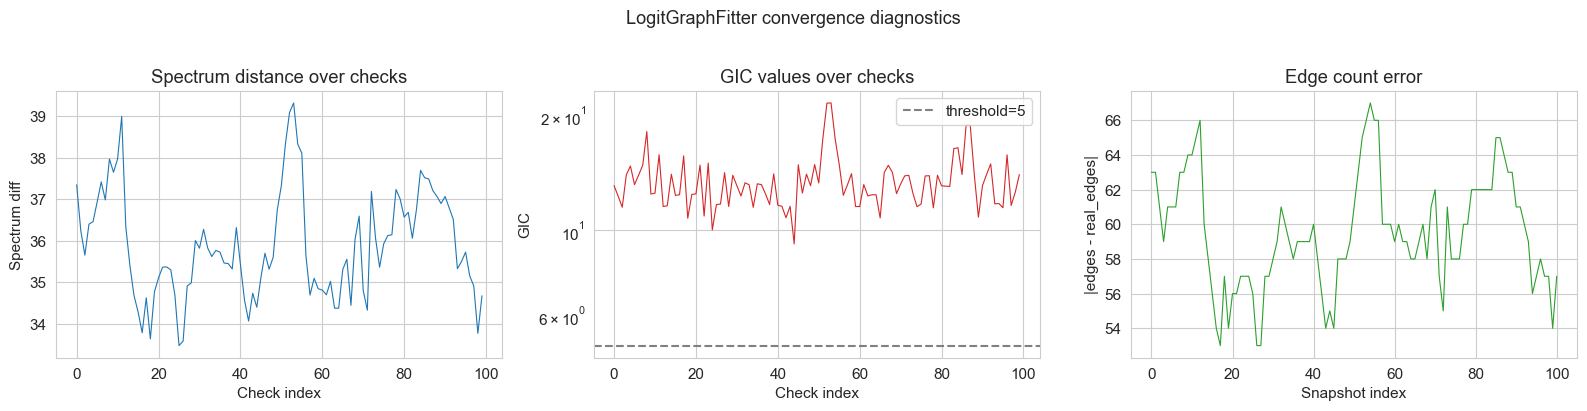

In [12]:
# Plot the convergence diagnostics stored in fitter metadata
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sd = fitter.metadata.get('spectrum_diffs', [])
gv = fitter.metadata.get('gic_values', [])
ed = fitter.metadata.get('edge_diffs', [])

if sd:
    axes[0].plot(sd, '-', color='tab:blue', linewidth=0.8)
    axes[0].set_xlabel('Check index'); axes[0].set_ylabel('Spectrum diff')
    axes[0].set_title('Spectrum distance over checks')

if gv:
    axes[1].plot(gv, '-', color='tab:red', linewidth=0.8)
    axes[1].axhline(5, ls='--', color='gray', label='threshold=5')
    axes[1].set_xlabel('Check index'); axes[1].set_ylabel('GIC')
    axes[1].set_title('GIC values over checks'); axes[1].legend()
    axes[1].set_yscale('log')

if ed:
    axes[2].plot(ed, '-', color='tab:green', linewidth=0.8)
    axes[2].set_xlabel('Snapshot index'); axes[2].set_ylabel('|edges - real_edges|')
    axes[2].set_title('Edge count error')

plt.suptitle('LogitGraphFitter convergence diagnostics', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 6. End-to-end `LogitGraphSimulation`

`LogitGraphSimulation` now accepts `check_interval`, `edge_cv_tol`, and
`spectrum_cv_tol` and forwards them to `populate_edges_baseline`.

In [13]:
sim = LogitGraphSimulation(
    n=G_small.number_of_nodes(),
    d=1,
    sigma=sigma_est,
    beta=beta_est,
    er_p=0.05,
    n_iteration=8000,
    warm_up=500,
    patience=15,
    check_interval=50,
    edge_cv_tol=0.02,
    spectrum_cv_tol=0.02,
    verbose=True,
)
sim.simulate()

print('\n=== Simulation Metadata ===')
for k in ['simulate_success', 'final_nodes', 'final_edges']:
    print(f'  {k}: {sim.metadata.get(k)}')

assert sim.metadata.get('simulate_success'), 'FAIL: simulation did not succeed'
print('\nPASS: LogitGraphSimulation completed successfully with CV-based convergence.')


==================== Simulating Logit Graph ====================
Parameters - n: 29, d: 1, sigma: -3.1754, alpha: 1.0000, beta: 0.0253, er_p: 0.05


Generating graph:   0%|          | 0/8000 [00:00<?, ?it/s]

Simulation successful - Nodes: 29, Edges: 17

=== Simulation Metadata ===
  simulate_success: True
  final_nodes: 29
  final_edges: 17

PASS: LogitGraphSimulation completed successfully with CV-based convergence.


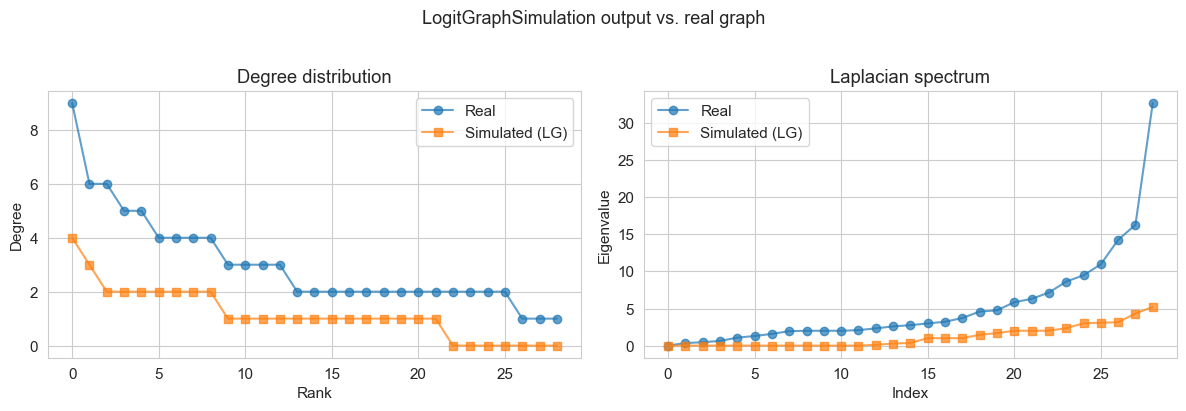

In [14]:
G_sim = sim.simulated_graph

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

deg_real = sorted([d for _, d in G_small.degree()], reverse=True)
deg_sim = sorted([d for _, d in G_sim.degree()], reverse=True)
axes[0].plot(deg_real, 'o-', label='Real', alpha=0.7)
axes[0].plot(deg_sim, 's-', label='Simulated (LG)', alpha=0.7)
axes[0].set_xlabel('Rank'); axes[0].set_ylabel('Degree')
axes[0].set_title('Degree distribution'); axes[0].legend()

spec_real = GraphModel.calculate_spectrum(adj_small)
spec_sim = GraphModel.calculate_spectrum(nx.to_numpy_array(G_sim))
axes[1].plot(spec_real, 'o-', label='Real', alpha=0.7)
axes[1].plot(spec_sim, 's-', label='Simulated (LG)', alpha=0.7)
axes[1].set_xlabel('Index'); axes[1].set_ylabel('Eigenvalue')
axes[1].set_title('Laplacian spectrum'); axes[1].legend()

plt.suptitle('LogitGraphSimulation output vs. real graph', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 7. Medium-sized graph test (65 nodes)

Repeat the fitter test on the medium-sized connectome to verify that
`check_interval` produces meaningful savings on a larger graph.

In [15]:
adj_medium = nx.to_numpy_array(G_medium)

# Estimate parameters
est_m = LogitRegEstimator(adj_medium, d=1)
features_m, labels_m = est_m.get_features_labels()
_, params_m, _ = est_m.estimate_parameters(l1_wt=1, alpha=0, features=features_m, labels=labels_m)
sigma_m, beta_m = params_m[0], params_m[1]
print(f'Medium graph — sigma={sigma_m:.4f}, beta={beta_m:.4f}')

n_m = G_medium.number_of_nodes()

# Run with check_interval=50 vs check_interval=1 (old behavior) to time the difference
for ci_label, ci in [('new (ci=50)', 50), ('old-style (ci=1)', 1)]:
    np.random.seed(7)
    gm_m = GraphModel(n=n_m, d=1, sigma=sigma_m, beta=beta_m, er_p=0.05)
    t0 = time.time()
    _, _, sd_m, bi_m, bg_m, gv_m = gm_m.populate_edges_spectrum_min_gic(
        max_iterations=2000, patience=20, real_graph=adj_medium,
        min_gic_threshold=5, check_interval=ci, verbose=False,
    )
    elapsed = time.time() - t0
    spec_diff = float(np.linalg.norm(
        GraphModel.calculate_spectrum(bg_m) - GraphModel.calculate_spectrum(adj_medium)))
    print(f'  {ci_label:>20}: time={elapsed:.2f}s  spec_diff={spec_diff:.4f}  '
          f'n_checks={len(sd_m)}  best_iter={bi_m}')

Medium graph — sigma=-4.6667, beta=0.0031
           new (ci=50): time=0.10s  spec_diff=167.6707  n_checks=21  best_iter=0
      old-style (ci=1): time=0.11s  spec_diff=165.4911  n_checks=51  best_iter=0


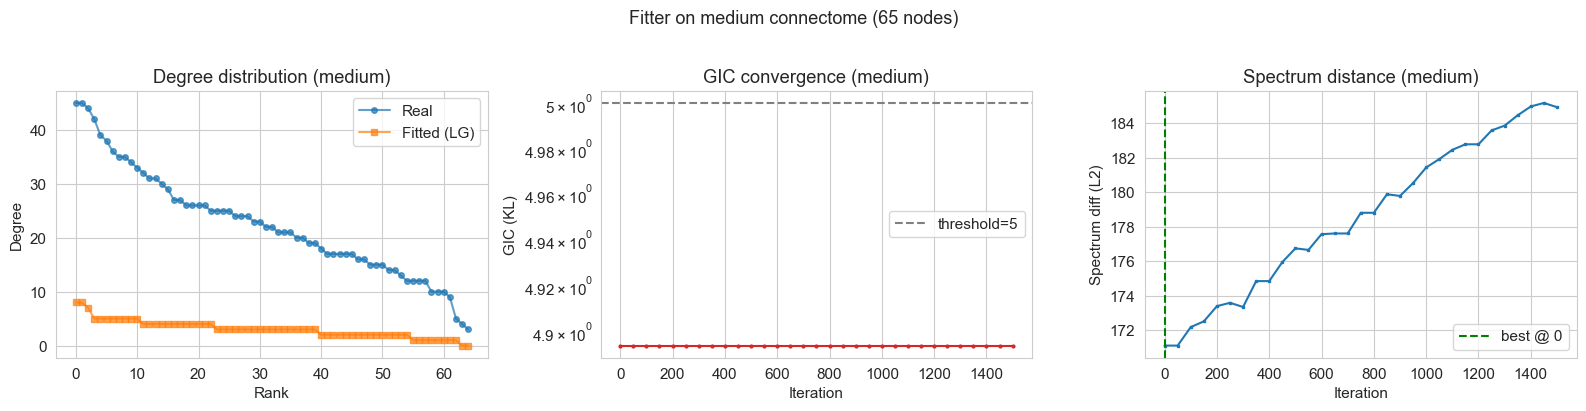

Final GIC (KL) of best graph on medium connectome: 4.8936


In [16]:
# Run the fitter with check_interval=50 and visualise
np.random.seed(7)
gm_m2 = GraphModel(n=n_m, d=1, sigma=sigma_m, beta=beta_m, er_p=0.05)
_, _, sd_m2, bi_m2, bg_m2, gv_m2 = gm_m2.populate_edges_spectrum_min_gic(
    max_iterations=3000, patience=30, real_graph=adj_medium,
    min_gic_threshold=5, check_interval=50, verbose=False,
)

G_fitted_m = nx.from_numpy_array(bg_m2)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

deg_real_m = sorted([d for _, d in G_medium.degree()], reverse=True)
deg_fit_m = sorted([d for _, d in G_fitted_m.degree()], reverse=True)
axes[0].plot(deg_real_m, 'o-', label='Real', alpha=0.7, markersize=4)
axes[0].plot(deg_fit_m, 's-', label='Fitted (LG)', alpha=0.7, markersize=4)
axes[0].set_xlabel('Rank'); axes[0].set_ylabel('Degree')
axes[0].set_title('Degree distribution (medium)'); axes[0].legend()

check_iters = np.arange(len(gv_m2)) * 50
axes[1].plot(check_iters, gv_m2, 'o-', markersize=2, color='tab:red')
axes[1].axhline(5, ls='--', color='gray', label='threshold=5')
axes[1].set_xlabel('Iteration'); axes[1].set_ylabel('GIC (KL)')
axes[1].set_title('GIC convergence (medium)'); axes[1].legend()
axes[1].set_yscale('log')

check_iters_s = np.arange(len(sd_m2)) * 50
axes[2].plot(check_iters_s, sd_m2, 's-', markersize=2, color='tab:blue')
axes[2].axvline(bi_m2, ls='--', color='green', label=f'best @ {bi_m2}')
axes[2].set_xlabel('Iteration'); axes[2].set_ylabel('Spectrum diff (L2)')
axes[2].set_title('Spectrum distance (medium)'); axes[2].legend()

plt.suptitle('Fitter on medium connectome (65 nodes)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Final GIC of the best graph
gic_final = GraphInformationCriterion(
    graph=G_medium, model='LG',
    log_graph=G_fitted_m, dist='KL'
).calculate_gic()
print(f'Final GIC (KL) of best graph on medium connectome: {gic_final:.4f}')

---
## 8. `GraphModelComparator` with `check_interval`

The comparator passes `lg_params` (which can include `check_interval`)
through to the fitter.

In [17]:
comparator = GraphModelComparator(
    d_list=[0, 1],
    lg_params={
        'max_iterations': 3000,
        'patience': 25,
        'edge_delta': None,
        'min_gic_threshold': 5,
        'er_p': 0.05,
        'check_interval': 50,   # <-- new parameter
    },
    other_model_n_runs=3,
    dist_type='KL',
    verbose=True,
    other_models=['ER', 'WS', 'BA'],
    other_model_params=[
        {'lo': 0.01, 'hi': 0.25},
        {'k': {'lo': 2, 'hi': 10, 'step': 2}, 'p': {'lo': 0.01, 'hi': 0.5}},
        {'lo': 1, 'hi': 8},
    ],
    other_model_grid_points=5,
)
comparator.compare(original_graph=G_small, graph_filepath='mouse_visual.cortex_1.graphml')

print('\n=== Summary ===')
display(comparator.summary_df)


============================== Processing Graph: mouse_visual.cortex_1.graphml ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


Optimizing Graph:   0%|          | 0/3000 [00:00<?, ?it/s] 


Stopping: max iterations (3,000) reached
  Best iteration: 1,850
  Best spectrum diff: 31.4987
  Edges in best graph: 28 (real: 77)
d=0: GIC=13.3188, sigma=-3.3084
Running LG generation for d=1...


Optimizing Graph:   0%|          | 0/3000 [00:00<?, ?it/s] 


Stopping: max iterations (3,000) reached
  Best iteration: 2,650
  Best spectrum diff: 30.2871
  Edges in best graph: 29 (real: 77)
d=1: GIC=11.5866, sigma=-3.1754
Best LG fit found with GIC: 11.5866

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.111557108726663
Testing the selected model for WS
WS gic: 2.299086521850259
Testing the selected model for BA
BA gic: 5.899939681486961
WS fitting - GIC: 2.2991, Param: 20.3775
ER fitting - GIC: 3.1116, Param: 0.0700
BA fitting - GIC: 5.8999, Param: 1.0000

--- Calculating graph attributes ---

=== Summary ===


,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,mouse_visual.cortex_1.graphml,Original,NaN,N/A,True,29,44,0.108374,0.049425,2.940887,6,-0.470896,1,29
1,mouse_visual.cortex_1.graphml,LG,11.586609,"d=1, sigma=-3.1754",True,29,29,0.071429,0.112808,3.543333,8,-0.257556,5,25
2,mouse_visual.cortex_1.graphml,WS,2.299087,20.3775,True,29,58,0.142857,0.104762,2.403941,4,-0.105240,1,29
3,mouse_visual.cortex_1.graphml,ER,3.111557,0.07,True,29,31,0.076355,0.000000,3.025362,6,-0.182512,5,24
4,mouse_visual.cortex_1.graphml,BA,5.899940,1.0,True,29,28,0.068966,0.000000,3.118227,6,-0.414605,1,29
